## Supervised learning (Regression)

In supervised learning, the task is to infer hidden structure from labeled data, comprised of training examples $\{(x_n, y_n)\}$, Regression (typically) means the output y takes continuous values.

We demonstrate how to do this in Edward with an example. The script is available [here](https://github.com/blei-lab/edward/blob/master/examples/bayesian_linear_regression.py).

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal
from scipy.stats import norm
%matplotlib inline

We build our toy dataset. They comprise of
pairs of inputs $\mathbf{x}_n\in\mathbb{R}^{10}$ and outputs
$y_n\in\mathbb{R}$. They have a linear dependence with normally
distributed noise.

In [2]:
def build_toy_dataset(N, noise_std=0.5):
  X = np.concatenate([np.linspace(0, 2, num=N / 2),
                      np.linspace(6, 8, num=N / 2)])
  y = 2.0 * X + 10 * norm.rvs(0, noise_std, size=N)
  X = X.reshape((N, 1))
  return X.astype(np.float32), y.astype(np.float32)

 Simulate training and test sets of $40$ data points.

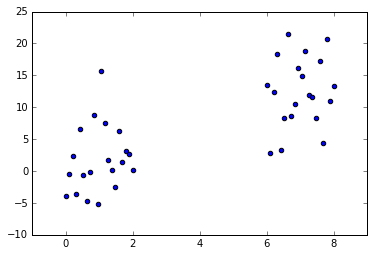

In [3]:
N = 40  # num data points
D = 1  # num features

# DATA
X_train, y_train = build_toy_dataset(N)
X_test, y_test = build_toy_dataset(N)

plt.scatter(X_train, y_train);

### Model

Posit the model as Bayesian linear regression. For more details on the model, see the [Bayesian linear regression tutorial](http://edwardlib.org/tutorials/bayesian-linear-regression).

Here we build the model in Edward’s native language.

In [4]:
# MODEL

# placeholder for the data
X = tf.placeholder(tf.float32, [N, D])

# priors on the latent variables
w = Normal(mu=tf.zeros(D), sigma=tf.ones(D))
b = Normal(mu=tf.zeros(1), sigma=tf.ones(1))

# likelihood of the data
y = Normal(mu=ed.dot(X, w) + b, sigma=tf.ones(N))

### Inference

Perform variational inference. Define the variational model to be a fully factorized normal across the weights.

In [5]:
# INFERENCE
qw = Normal(mu=tf.Variable(tf.random_normal([D])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(mu=tf.Variable(tf.random_normal([1])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

Run mean-field variational inference for 1000 iterations.

In [6]:
data = {X: X_train, y: y_train}
inference = ed.KLqp({w: qw, b: qb}, data)
inference.run()

Iteration    1 [  0%]: Loss = 4738.075
Iteration  100 [ 10%]: Loss = 579.660
Iteration  200 [ 20%]: Loss = 561.478
Iteration  300 [ 30%]: Loss = 562.105
Iteration  400 [ 40%]: Loss = 563.877
Iteration  500 [ 50%]: Loss = 563.658
Iteration  600 [ 60%]: Loss = 563.810
Iteration  700 [ 70%]: Loss = 563.222
Iteration  800 [ 80%]: Loss = 563.794
Iteration  900 [ 90%]: Loss = 562.205
Iteration 1000 [100%]: Loss = 562.106


In this case we minimize with the $\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the $\text{KL}(q\|p)$ tutorial} - [link](http://edwardlib.org/tutorials/klqp)

### Critisicm 

Use point-based evaluation, and calculate the mean squared error for predictions on test data.

We do this first by forming the posterior predictive distribution.

In [7]:
# CRITICISM
y_post = ed.copy(y, {w: qw.mean(), b: qb.mean()})
# This is equivalent to
# y_post = Normal(mu=ed.dot(X, qw.mean()) + qb.mean(), sigma=tf.ones(N))

Evaluate predictions from the posterior predictive.

In [8]:
print("test mean squared error: {:.3f}".format(
        ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test})))

test mean squared error: 37.028


The trained model makes predictions with low mean squared error (relative to the magnitude of the output).

### Visualisation

Let's visualise the samples from the prior and the posterior.
Let's first define a small helper method which does the visualisation for us.

In [9]:
def visualise(X_train, y_train, n_samples, w, b):
    # first we sample from the distribution
    w_samples = w.sample(n_samples).eval()
    b_samples = b.sample(n_samples).eval()
    # set up plotting
    plt.scatter(X_train, y_train)
    inputs = np.linspace(-1, 10, num=400, dtype=np.float32)
    for ns in range(n_samples):
        output = inputs * w_samples[ns] + b_samples[ns]
        plt.plot(inputs, output)

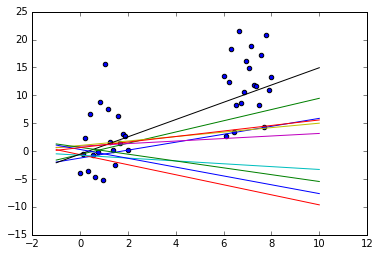

In [10]:
# samples from the prior
n_prior_samples = 10

# we pass w and b as it is the prior
visualise(X_train, y_train, n_prior_samples, w, b)

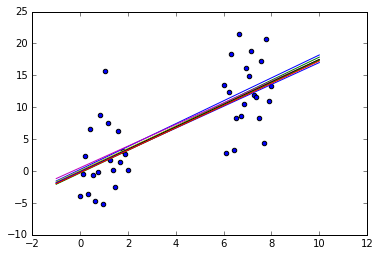

In [11]:
# samples from the posterior
n_posterior_samples = 10

# we pass qw and qb as it is the posterior
visualise(X_train, y_train, n_posterior_samples, qw, qb)